# Report: Inbound Logistics Forecasting Benchmark

## Introduction and data

<img src="../img/Area_Forwarding_based_inbound_logistics.png" alt="moirai model" width=350>

**Introduction**

The problem at hand refers to forecasting the inbound material volume (in tons) on monthly basis for the next 4 months for an international automotive company. For all main legs of the Area-Forwarding based Inbound Logistics Network, as shown in the image above. The motivation behind that was the lack of synchronization between suppliers and freight forwarders systems, causing over- or under-capacity planning whenever a plant’s material demands change abruptly, leading to higher logistics transportation costs. 

I published a paper last year about this system, as a result of a research on inbound forecasting systems that I started in 2018. It can be found here [Forecasting System for Inbound Logistics Material Flows at an International Automotive Company](https://www.mdpi.com/2673-4591/39/1/75). Howerver this codebase was written in R using the forecasting package [forecast](https://cran.r-project.org/package=forecast) by Robert Hyndman and George Athanasopoulos in their book [Forecasting at Scale](https://otexts.com/fpp3/). It included algorithms like SARIMA, Exponential Smoothing, Multilayer Neural Networks, Prophet and Vector Autoregression. At that point in time the python packages for timeseries forecasting were not as good as R's. However, the python ecosystem for forecasting has grown a lot in the recent years. There are Python packages like [nitxla](https://nixtlaverse.nixtla.io/), [lightgbm](https://lightgbm.readthedocs.io/en/latest/Python-API.html), [catboost](https://catboost.ai/), as well as LLM forecasting models like [chronos](https://huggingface.co/amazon/chronos-t5-large) that offer many additional functionalities to leverage the use of new algorithms. 

In the M5 competition results [link](https://www.sciencedirect.com/science/article/pii/S0169207021001874) it was shown that boosted tree models can outperform traditional statistical and deep learning forecasting methods. This is something we will be exploring in this project. 

In addition, I would like to use the historical covid numbers from the [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/covid-19/data) to evaluate the influence of this variable on the accuracy of the predictions. This is something that has not been explored in research.

**Research question**: *Which new methods can be used to improve the forecasting accuracy for the Inbound Logistics Volume of an International Automotive Company?*

The idea is to create a forecasting system which is accurate and robust to adapt for outliers and unexpected events( e.g. COVID-19). To evaluate the forecast accuracy the `MAE (Mean Absolute Error)` and `SMAPE (Symmetric Mean Absolute Error)` will be used. This will allow us to care about the fact that in some months the transportation volume could have been 0. 

The test timeframes are: Jan 2022 - Apr 2022, May 2022 - Aug 2022, Jul 2022 - Oct 2022. This means that models tested in each frame can only be trained with data prior to that frame to avoid data leakage. 

One of the main Business KPI's to track forecast accuracy will be how many timeseries are in a particular `SMAPE` range, for that we will use the following intervals: 0% to 10%, 10 to 20%, 20 to 30%, 30 to 40%, greater than 40%. The business experts are particularly interested in having a forecating systems for which most of the timeseries have a `SMAPE` of less or equal than 20%.

**Hypothesis**: *There are new forecasting methods which can deliver better accuracy than traditional statistical methods*


### Data description

There are two dataset, one containing the historical volume data, another one containing the production data. In total there are:

- 624  inbound logistics Provider-Plant connections
- 18  plants
- 38  Providers

The historical transport volume data contains data since 2014-01-01 until 2022-10-01.
The historical production data contains data since 2014-01-01 until 2023-12-01. All data until October 2022 is actual produced values, the rest are planning values.

The two input data sources for this project are:

- **Inbound_Volume_Data.csv** contains the historical transported material volume since January 2014 until October 2022 on monthly basis. This data comes from the Logistics Parts Mangement System. 
    - **Timestamp**: Monthly data of the format YYYY/MM.
    - **Provider**: Logistics Service Provider.
    - **Plant**: Assembly Plant. 
    - **Actual Vol [Kg]**: Actual transported volume from Provider to Plant in kg. 
    - **Expected Vol [Kg]**: Expected transported volume from Provider to Plant in kg. $^1$
- **production_data.csv** contains the historical production levels of all the european plants in number of vehicles per month from January 2014 until October 2022. Data after October 2022 refers to planned production values. 
    - **Timestamp**:  Monthly data of the format YYYY/MM.
    - **Plant_X**: Column containing the production level for Plant X.

$^1$ *Expected in this context means the volume value which the internal ERP system would calculate. That means, given the number of units in the call-off order and using the weights of the parts, the total expected weight of a delivery can be calculated. However, as mentioned before, due to the sync issue, the delivered volume and expected volume would differ.*

Additionally, I will use the **monthly_covid_rate_per_country.parquet** file, which is generated after pivoting the file **Covid-19_cases_age_specific.csv** to monthly values per country as columns.

- **Covid-19_cases_age_specific.csv**: This data file contains information on the 14-day notification rate of newly reported COVID-19 cases per 100 000 population by age group, week and country. Each row contains the corresponding data for a certain week and country. The file is updated weekly. [source](https://www.ecdc.europa.eu/en/publications-data/covid-19-data-14-day-age-notification-rate-new-cases). The Covid data ranges from 2020-01-06 until 2023-11-20.
    - **country**: Country name
    - **country_code**: cuontry code
    - **year_week**: YYYY-WW data
    - **age_group**: age group
    - **new_cases**: new covid cases
    - **population**: population 
    - **rate_14_day_per_100k**: covid rate per 100.000 inhabitants
    - **source**: Covid source type

- The **monthly_covid_rate_per_country.parquet**, contains the monthly 14-day notification of newly reported COVID-19 cases per 100 000 population per european contry. The Covid data ranges from 2020-01-06 until 2023-11-20. This file is a pivoted version of the original file, for which each row represents a month and each column a country with its corresponding covid cases. Columns are: 
    - **Timestamp**: Monthly date of the format YYYY-MM-DD
    - **Country**: Monthly COVID-19 Rate Per 100k (14-Day Average) in the given country

The **Inbound_Volume_Data** and **production_data** were obtained from the ERP System of the company and were annonymized for research purposes. The Covid **Covid-19_cases_age_specific.csv** data is available on the website of the European Centre for Disease Prevention and Control.

#### Packages & Functions

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.insert(0, os.path.abspath('..'))

# Import all the necessary libraries
from src.project_imports import *

### Data Dictionary

#### Historical Volume Data

In [2]:
print(data_dict_vol.to_markdown(index=False))

| Name                | Description                                                | Role      | Type    | Format   |
|:--------------------|:-----------------------------------------------------------|:----------|:--------|:---------|
| Timestamp           | Monthly date of the format YYYY-MM-DD                      | ID        | ordinal | datetime |
| Provider            | Logistics Provider ID                                      | ID        | nominal | category |
| Plant               | Assembly Plant ID                                          | ID        | nominal | category |
| Actual_Vol_[Kg]     | Actual transported volume from Provider to Plant in kg     | response  | numeric | float    |
| Expected_Vol_[Kg]   | Expected transported volume from Provider to Plant in kg   | predictor | numeric | float    |
| Year                | Year in which transport took place                         | predictor | numeric | int      |
| Month               | Month in which transport took pl

#### Historical Production Planning

In [3]:
print(data_dict_prod.to_markdown(index=False))

| Name       | Description                           | Role      | Type    | Format   |
|:-----------|:--------------------------------------|:----------|:--------|:---------|
| Timestamp  | Monthly date of the format YYYY-MM-DD | ID        | ordinal | datetime |
| Plant      | Assembly Plant ID                     | ID        | nominal | category |
| Production | Production Volume in Number of Units  | predictor | numeric | int      |


#### Covid Data

In [4]:
print(data_dict_covid.to_markdown(index=False))

| Name      | Description                                                          | Role      | Type    | Format   |
|:----------|:---------------------------------------------------------------------|:----------|:--------|:---------|
| Timestamp | Monthly date of the format YYYY-MM-DD                                | ID        | ordinal | datetime |
| Country   | Monthly COVID-19 Rate Per 100k (14-Day Average) in the given country | predictor | numeric | float    |


## Methodology

### Config File

This configuration file is used to define various paths and parameters for data preprocessing, data quality checks, and feature engineering in the data analytics project. This is best practice in software projects to use `config` files, I always use this files whenever I create any project.

### Import data

In [5]:
config = read_config(yaml_file_path="../config.yaml")
df_vol = pd.read_csv(config['preprocessing']['vol_data_path'],index_col=0)
df_prod = pd.read_csv(config['preprocessing']['prod_data_path'],index_col=0)
df_covid = pd.read_csv(config['preprocessing']['covid_data_path'])

### Data Preparation & Data Quality

In this step we adjust the data as well as apply multiple data quality checks, and data completeness to make sure that the timeseries contain data at all timestamps and that they all have the same length.  

#### Preparation Historical Volume Data

In [6]:
df_vol_bronze = df_vol.copy()
df_vol_gold = data_preparation_and_data_quality(config=config, df_vol_bronze=df_vol_bronze)

The historical transport volume data contains data since 2014-01-01 00:00:00  until  2022-10-01 00:00:00
in Total it contains data for 624  inbound logistics Provider-Plant connections
in Total it contains data for 18  plants
in Total it contains data for 38  Providers
in Total it contains  47058  rows.
in Total it contains  10  columns.
 The min date available among all timeseries is:  2014-01-01 00:00:00
 The max date available among all timeseries is:  2022-10-01 00:00:00
 The min ts length is:  1
 The max ts length is:  113
 Number of time series with data until October 2022:  306
 Number of Total Time Series Available:  624
 Number of Total Time Series Available for Prediction:  49.0  %
Number of available timeseries after first filtering: 306
 The min ts length is  1
 The max ts length is  113
 The mean ts length is  97.5268455014001
 TS to forecast with Models 266
 TS to forecast with Models 87.0  %


The previous analysis shows us how important it is to verify which time series actually meet the criteria and have the desired data quality for forecasting. In our case, we found out that only 266 out of 624, that is 42% of all time series are available at the last max date and meet the business criteria for forecasting. That is to say, most data was either outdated (material connections not existing anymore) or are not relevant for the business.

The 266 are the timeseries that will be relevant for forecasting. From now on, we will focus on these time series to analyze their patterns and create the forecast.

#### Preparation Production Data

In [7]:
df_prod_bronze = df_prod.copy()
df_prod = preparation_production_data(config=config, df_prod_bronze=df_prod_bronze)

The historical production data contains data since 2014-01-01 00:00:00  until  2023-12-01 00:00:00
in Total it contains  2160  rows.
in Total it contains  3  columns.
Total available Plants are:  18
Max Production Volume was:  409207  units. In 2015-07-01T00:00:00.000000000
Min Production Volume was:  0  units. In 2020-04-01T00:00:00.000000000


#### Preparation Covid Data

In [8]:
df_covid_bronze = df_covid.copy() 
df_covid = preprocesing_covid(df_covid=df_covid_bronze)
df_covid.to_parquet(config['preprocessing']['covid_silver_path'])

The Covid data ranges from 2020-01-06 00:00:00  until  2023-11-20 00:00:00
The file contains data for  29  countries.
The file contains data for  6  age groups  ['<15yr' '15-24yr' '25-49yr' '50-64yr' '65-79yr' '80+yr']
in Total it contains  35496  rows.
in Total it contains  9  columns.


### Exploratory Data Analysis

In [9]:
df_vol_gold.head(2)

,Timestamp,ts_key,Actual_Vol_[Tons],Expected_Vol_[Tons],Plant
0,2014-01-01,Provider_10-Plant_10,476.199005,482.835999,Plant_10
1,2014-02-01,Provider_10-Plant_10,388.113007,388.118011,Plant_10


### Response Variable

Our Response variable is the **Actual_Vol_[Tons]**. However, the **Production Planning Data**  would be used as a smoothing factor to transform the response variable into the so called `Vol/Prod Ratio`. Because the production data and the inbound volume have a natural correlation. We can use this relationship to create a new target variable that will compensate for variations in the inbound volume. This new variable will be called `Vol/Prod Ratio`. 

This approach is possible since the production planning data is always available on monthly basis for the next 12 months in the future. So if we use `Vol/Prod Ratio` instead of `Actual Vol [Kg]` to train the model, we can then easly multiply the forecast values of `Vol/Prod Ratio` with the Production Planning values to get the forecast of `Actual Vol [Kg]`. 

#### Merge Production Information to Historical Inbound Volume Data

In [10]:
df_ratio_gold = generate_vol_prod_ratio_gold(df_vol_gold=df_vol_gold, df_prod=df_prod)

#### Volume/Production Ratio Analysis

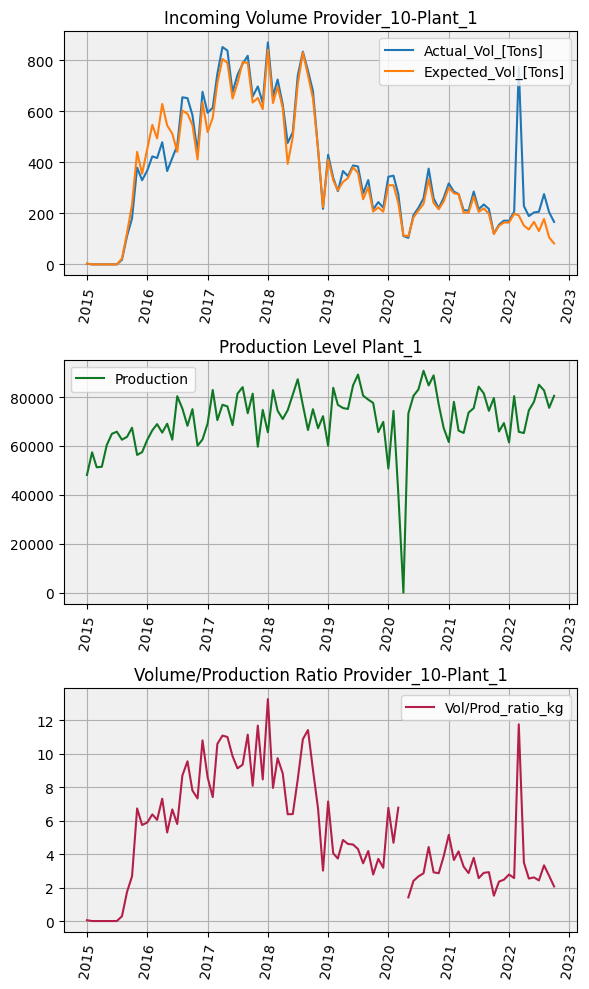

In [11]:
ts_key = 'Provider_10-Plant_1'
plot_ratio_vol_prod(ts_key=ts_key, df_ratio=df_ratio_gold) 

This visualization is very powerful. We can see how the Volume/Production ratio is closely related to the patterns from the production values as well as the historical inbound volume. 

#### Linear Interpolation

Another important factor when working with time series is to make sure we have data for all of our timestamps. Due to the Covid outbrake, April 2020 was a month in which no production took place. However, some inbound volume did flow into the plants. Therefore, when we calculate the volume/production ratio, we will not get any data because we would be calculating a division over 0.

In [12]:
# Apply 1st order polynomial interpolation
df_ratio_gold['Vol/Prod_ratio_kg'] = df_ratio_gold['Vol/Prod_ratio_kg'].interpolate(method='polynomial', order=1)
# Store ratio data to Gold layer
df_ratio_gold.to_parquet(config['preprocessing']['ratio_gold_path'])
# Create PDF Reaport of all ratios
#plot_ratio_all_ts(df_ratio=df_ratio_gold, path=config['preprocessing']['pdf_report_ratios_path'])

### Timeseries Analysis

Based on `Konrad Banachewicz` full time series course on [Kaggle](https://www.kaggle.com/code/konradb/ts-0-the-basics). We can analize different factors in our timeseries. One powerful tool, is the seasonal decomposition; in particular the additve model.  The additive model for seasonal decomposition is used to break down a time series into three components: **T[t]**: The trend component, which captures the long-term movement or direction of the data over time. **S[t]**: The seasonal component, representing repeating patterns or cycles that occur at regular intervals (e.g., monthly, yearly). **e[t]**: The residual or error component, which accounts for random fluctuations or noise that cannot be explained by the trend or seasonality.

The model assumes that the time series $ Y[t] $ is the sum of these components at any time $t $:

$
Y[t] = T[t] + S[t] + e[t]
$

Since we have a strong seasonal component in the data, i.e. incoming volume is lower in the winter and summer peaks due to vacations, and higher in other months. We can use this method to generate features that can then be used by machine learning models. When it comes to univariate statistical models, they should be able to pick out these trends by themselves. A good example of these models is the ARIMA model. We can use this data and back fill and forward fill the missing values (missing values due to the 12-month seasonal parameter) as new featuers and add them to new table `timeseries_features_gold`.

In [13]:
df_ts_decomposition = features_seasonal_decomposition(df_ratio_gold=df_ratio_gold, target_col=config['feature_eng']['target_col'])
df_ts_decomposition.to_parquet(config['preprocessing']['seasonal_feat_gold_path'])
df_ts_decomposition.head(2)

,trend,sesonality,residuals,ts_key,Timestamp
20004,1.678919,1.267479,-0.87061,Provider_10-Plant_1,2015-01-01
20005,1.678919,-0.609561,-0.87061,Provider_10-Plant_1,2015-02-01


### Feature Engineering


Feature engineering in machine learning is the process of selecting, transforming, and creating new input variables (features) from raw data to improve the performance of models. It involves domain knowledge and various techniques like scaling, encoding, or generating new features, helping algorithms better capture underlying patterns in the data. The goal is to enhance model accuracy and predictive power by providing more meaningful data inputs.

In timeseries forecasting tasks common features engineering techniques are: 

- Lag Features
- Rolling Features
- Statistical Analysis Features like mean, stadard deviation. 

References can be found here [Feature Engineering for Timeseries](https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter06/01-Feature%20Engineering.ipynb) from the book [Modern Timeseries Forecasting with Python](https://www.oreilly.com/library/view/modern-time-series/9781835883181/)

In [14]:
df_timeseries_gold = main_feature_engineering(config=config)
df_timeseries_gold.head(2)

,Timestamp,ts_key,Plant,Production,Vol/Prod_ratio_kg,ts_len,Provider,Month,Year,Vol/Prod_ratio_kg_Lag_2,...,Spain_Rolling_std_12,Sweden_Lag_4,Sweden_Lag_6,Sweden_Lag_12,Sweden_Rolling_Mean_4,Sweden_Rolling_std_4,Sweden_Rolling_Mean_6,Sweden_Rolling_std_6,Sweden_Rolling_Mean_12,Sweden_Rolling_std_12
0,2015-01-01,Provider_10-Plant_1,Plant_1,48144,0.04869,94,Provider_10,1,2015,0.04869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-02-01,Provider_10-Plant_1,Plant_1,57400,0.00000,94,Provider_10,2,2015,0.04869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data splitting

In time series analysis, data splitting differs from traditional regression and classification problems because we must respect the temporal dependencies in the data. Unlike random splits, the validation and test datasets must always occur after the training dataset to ensure that future data is not used to predict past events, which would violate the time series structure.

To evaluate the models effectively, I will define three separate datasets: training, validation, and testing. The test datasets will correspond to the following timeframes:

- January 2022 – April 2022
- May 2022 – August 2022
- July 2022 – October 2022

In [15]:
# Create the Timestamps splits for Train, Validation and Test
# Train = [: shard[0]]
# Validation = [shard[1] : shard[2]]
# Test = [shard[3] : shard[4]]
shards = [
    [datetime(2021,8,1), datetime(2021,9,1), datetime(2021,12,1), datetime(2022,1,1), datetime(2022,4,1)],
    [datetime(2021,12,1), datetime(2022,1,1), datetime(2022,4,1), datetime(2022,5,1), datetime(2022,8,1)],
    [datetime(2022,2,1), datetime(2022,3,1), datetime(2022,6,1), datetime(2022,7,1), datetime(2022,10,1) ],
]

### Models

#### Statistical Models

**ARIMA**:(AutoRegressive Integrated Moving Average) is a forecasting method that combines autoregression, differencing, and moving averages to model and predict time series data based on its own past values and errors.

**Exponential Smoothing Models**: The exponential smoothing forecasting model is a method that predicts future data points by weighting past observations, giving more importance to recent data while gradually reducing the influence of older data

**WindowAverage**: The WindowAverage model forecasts future values by calculating the average of the most recent observations within a defined window of time, smoothing out short-term fluctuations.

The python package ecosystem `nixtla` contains multiple package for different timeseries tasks. The package [statsforecast](https://nixtlaverse.nixtla.io/#statsforecast), is optimized for applying automated versions of these models. 

#### Machine Learning Models

We will try out the Machine Learning Model known as boosted trees, in particular the algorithm LightGBM: 

**LightGBM** is a gradient boosting framework that uses tree-based learning algorithms to produce fast, efficient, and accurate predictions, particularly suited for large datasets and high-dimensional data

#### Deep Learning Models 

NeuralForecast offers a large collection of neural forecasting models focused on their usability, and robustness. The models range from classic networks like MLP, RNNs to novel proven contributions like NBEATS, NHITS, TFT and other architectures. [link](https://nixtlaverse.nixtla.io/neuralforecast/docs/getting-started/introduction.html)

**N-BEATS** (Neural Basis Expansion Analysis Time Series) is a deep learning model specifically designed for time series forecasting, focusing on trend and seasonality extraction through basis expansion.
  
**N-HiTS** (Neural Hierarchical Interpolation for Time Series) is a neural model that improves hierarchical time series prediction accuracy by generating fine-grained interpolations.

**TFT** (Temporal Fusion Transformer) is a model designed for interpretable, multivariate time series forecasting that combines temporal and static variables, using attention mechanisms to adaptively focus on relevant time points. However, we won`t be able to implement this model on the Mac ARM achitecture since the MPS device is still not supported in certain operations [mps_issue](https://github.com/pytorch/pytorch/issues/77764). Therefore we will use a Docker DevContainer.

### LLM Models 

**Chronos Bolt Model**: Chronos-Bolt is a family of pretrained time series forecasting models which can be used for zero-shot forecasting. It is based on the T5 encoder-decoder architecture and has been trained on nearly 100 billion time series observations. It chunks the historical time series context into patches of multiple observations, which are then input into the encoder. The decoder then uses these representations to directly generate quantile forecasts across multiple future steps—a method known as direct multi-step forecasting. Chronos-Bolt models are up to 250 times faster and 20 times more memory-efficient than the original Chronos models of the same size.

In [61]:
stats_models, df_stats_forecast = main_stats_models(df_timeseries_gold=df_timeseries_gold, shards=shards)

Forecasting for test frame 2022-01-01 - 2022-04-01


Forecasting for test frame 2022-05-01 - 2022-08-01
Forecasting for test frame 2022-07-01 - 2022-10-01
Object has been stored at ../models/stats_forecast.pkl.


In [62]:
lgbm_model, df_result_lgbm = main_lightgbm(df_timeseries_gold=df_timeseries_gold, shards=shards)

Train-Testing for 2022-01-01 2022-04-01
Best hyperparameters: {'learning_rate': 0.09260476161219532, 'num_leaves': 572, 'subsample': 0.2720140768577476, 'colsample_bytree': 0.5367103814708704, 'min_data_in_leaf': 86}
Best MAE: 2.7300686223038437
Train-Testing for 2022-05-01 2022-08-01
Best hyperparameters: {'learning_rate': 0.035268402255054156, 'num_leaves': 602, 'subsample': 0.998653106682182, 'colsample_bytree': 0.491474567857771, 'min_data_in_leaf': 56}
Best MAE: 4.096085600436597
Train-Testing for 2022-07-01 2022-10-01
Best hyperparameters: {'learning_rate': 0.09661309686765497, 'num_leaves': 806, 'subsample': 0.0620562262722254, 'colsample_bytree': 0.6857407119477501, 'min_data_in_leaf': 97}
Best MAE: 4.196667573807564
Object has been stored at ../models/lgbm_forecast.pkl.


In [ ]:
nf_model, df_result_deepl = main_deepl_models(df_timeseries_gold=df_timeseries_gold, shards=shards)

In [16]:
df_result_chronos = main_chronos(df_timeseries_gold=df_timeseries_gold, shards=shards)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Train-Testing for 2022-01-01 2022-04-01
Train-Testing for 2022-05-01 2022-08-01
Train-Testing for 2022-07-01 2022-10-01


**Morai Model**

To run Morai model, create a python env with the file requirements/morai_requirements.txt then run 

```bash
python forecast_morai.py
```


In [66]:
# Load all Results
df_stats_forecast = pd.read_parquet("../data/forecasts/stats_forecast.parquet")
df_result_lgbm = pd.read_parquet("../data/forecasts/lightgmb_forecast.parquet")
df_result_deepl = pd.read_parquet("../data/forecasts/deepl_forecast.parquet")
df_result_chronos = pd.read_parquet("../data/forecasts/chronos_bolt_forecast.parquet")
df_result_morai = pd.read_parquet("../data/forecasts/morai_forecast.parquet")

##### Feature Importance Analysis

Loaded object from ../models/lightgbm.pkl.


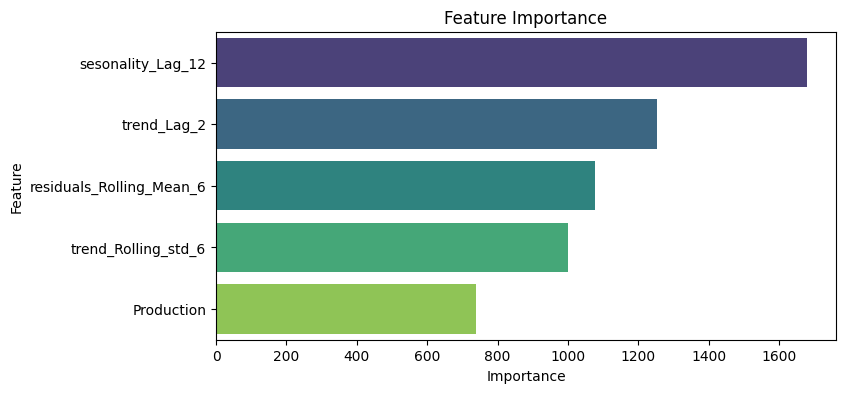

In [67]:
# TODO: Analyze COVID Impact
model_path="../models/lightgbm.pkl"
feature_importance_df = feature_importance_analysis(model_path=model_path, top=5)

Based on the feature importance plot we can see that the most important features are the seasonal features. This is expected as the data is seasonal and the model is able to capture the seasonality of the data. The following features are the lag based features as well as the historical production levels. Interestingly, COVID-related features had only little impact, with the first such feature **Poland_Rolling_std_4** ranking 54th out of the 351 available features.

#### Ensemble Model

Finally, I can create one last model, which will be an average combination of all models. This is a powerful technique proved by Claeskens *et al*, 2016 in their paper [The forecast combination puzzle: A simple theoretical explanation](https://www.sciencedirect.com/science/article/abs/pii/S0169207016000327)

In [69]:
df_true, df_forecats, evaluation_df, model_names = ensemble_model(config=config, 
                                            df_result_lgbm=df_result_lgbm, 
                                            df_stats_forecast=df_stats_forecast, 
                                            df_result_deepl=df_result_deepl, 
                                            df_result_chronos=df_result_chronos, 
                                            df_result_morai=df_result_morai)

In [70]:
evaluation_df.head(2)

,index,ts_key,Timestamp,y_true,LIGHTGBM,test_frame,AutoARIMA,AutoETS,CES,SeasonalNaive,...,AutoETS_target,CES_target,SeasonalNaive_target,WindowAverage_target,NBEATS_target,NHITS_target,TFT_target,CHRONOS_target,MORAI_target,Ensemble_target
0,0,Provider_10-Plant_1,2022-01-01,2.78201,4.079643,2022-01-01 - 2022-04-01,2.423550,2.37877,2.378803,5.15235,...,146158.783727,146160.793636,316575.84105,150641.339175,133284.261609,145885.360265,151482.010479,151580.643225,189899.721213,175567.678185
1,1,Provider_10-Plant_1,2022-02-01,2.56811,3.616801,2022-01-01 - 2022-04-01,2.444547,2.37877,2.378812,3.65084,...,191215.072035,191218.429810,293469.12256,197079.462400,193995.846436,192797.073242,198366.701904,179504.317139,243109.229614,215271.873502


## Results

### Evaluate Model Accuracy

Now we define the true values to evaluate the accuracy. Since we are using the `Vol/Prod_ratio_kg`. We have to multiply the forecast values with the Production values to get the forecast of `Actual Vol [Kg]`. These values will be called `y_target`. On the other hand, the `y_true` are the true `Vol/Prod_ratio_kg` values.

When using the models to forecast the real business data, this `Production` values are the `Production Planning` provided once a month for the following next 12 months. 

#### Plot SMAPE Intervals

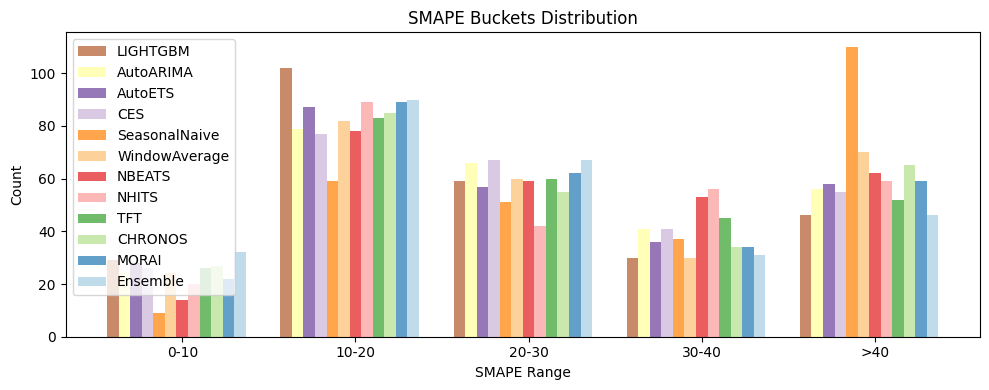

In [71]:
df_accuracy_smape, df_accuracy_mae = calculate_accuracy_metrics(evaluation_df, model_names)
buckets_data = plot_smape_buckets(df_accuracy_smape=df_accuracy_smape, model_names=model_names, figsize=(10,4))

This plot shows us how the different models perform in different SMAPE intervals. We can highlight that lightGBM and Ensemble Model are in the lead, having more forecasts in the lower interval ranges than the other models. We can also spot that the Sesonal Naive model is the worst model, delivering more than 100 timeseries with an SMAPE greater than 40.

In [72]:
df_acc_stats_models = pd.merge(df_accuracy_smape, df_accuracy_mae, on=['test_frame','ts_key','model_name'], how='left')
df_acc_stats_models = df_acc_stats_models[['test_frame','ts_key','model_name','smape','mae']].copy()
df_acc_stats_models[['model_name','smape','mae']].groupby(['model_name']).agg('mean').sort_values(by='smape', ascending=True)

,smape,mae
model_name,,
LIGHTGBM,32.163544,93657.839856
TFT,34.052732,93032.593300
Ensemble,34.447841,95774.012950
WindowAverage,36.474580,112085.249123
AutoETS,37.150981,99947.145352
MORAI,37.405243,97267.330927
CES,38.142503,103934.853783
AutoARIMA,38.378447,112685.363648
CHRONOS,39.011158,102846.965504


The previous dataframe shows us how the different models peform in the three test frames. We can spot how the LightGBM Model and the Ensemble model are consistently delivering values with low average SMAPE error.

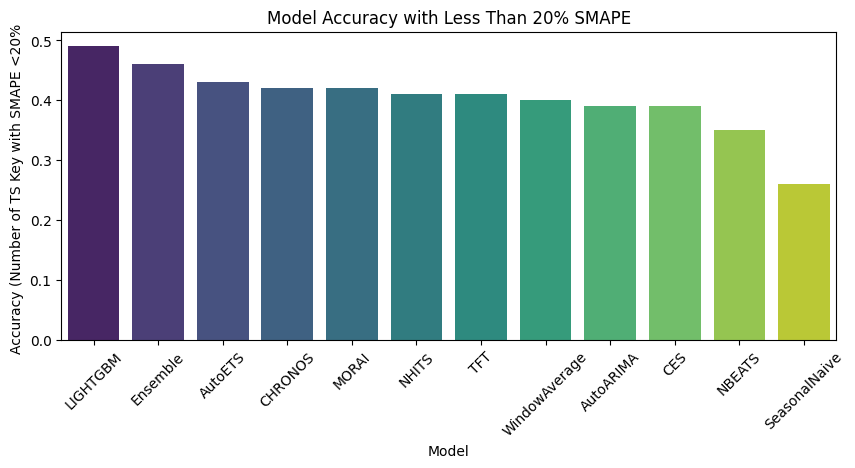

In [73]:
df_acc_less_20 = plot_err_less_20_SMAPE(buckets_data=buckets_data, figsize=(10,4))

Regarding the Business Accuracy target. We can see that the highest Number of timeseries with an SMAPE error of less than 20% is achieved by the LightGBM Model, with more than 50% of the forecast values, followed by the Ensemble Model. The worst performing model is the Seasonal Naive. 

### Forecating System - Analyze Best Forecasting Model per Timeseries

When it comes to forecasting systems. We can make the models compete to each other. For each timeseries we select the model with the lowest mean `SMAPE` across all test frames. With this we can increase the overall accuracy of all the predictions together, since some models would perform better than others in some timeseries. This is shown in my [paper](https://www.mdpi.com/2673-4591/39/1/75), however there I used a more complex metric (EWMA SMAPE - Exponentially Weighted Moving Average SMAPE) to pick the best performing mode. 

In [74]:
df_best_models, df_model_per_ts = calculate_best_models(df_accuracy_smape)
df_model_per_ts

,model_name,count
0,LIGHTGBM,103
1,Ensemble,30
2,WindowAverage,23
3,TFT,17
4,NHITS,17
5,MORAI,14
6,CES,14
7,AutoARIMA,13
8,CHRONOS,12
9,SeasonalNaive,10


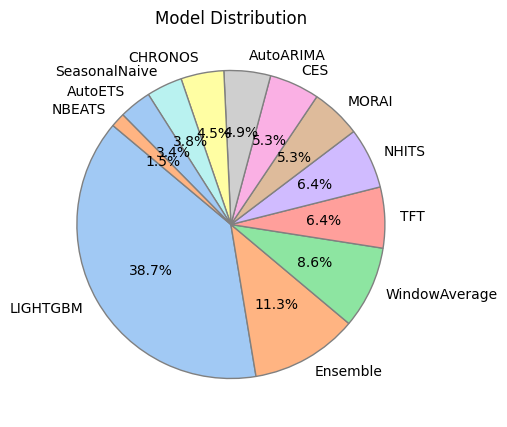

In [75]:
plot_model_distribution(df_model_per_ts=df_model_per_ts,figsize=(5,5))

The previous plot shows us a clear picture on which model is picked for which proportion of timeseries. 44.7% of timeseries are showing the lowest SMAPE when using the LightGBM Model, meanwhile 15.4% of timeseries perform the best when using the Ensemble model. Even though the seasonal Naive model is the worst model. This analysis shows us that 2.6% (7 timeseries) in total show better results when using this model instead of any other.

### Average Accuracy of Best Forecasting Models - Forecasting System

In [76]:
f_system_evaluation_df = forecast_system_evaluation_df(df_forecats, df_best_models, df_true)

##### Calculate MAE and SMAPE of Forecasting System

In [77]:
df_accuracy_smape, df_accuracy_mae = forecast_system_accuracy_metrics(evaluation_df=f_system_evaluation_df)
df_acc_stats_models = pd.merge(df_accuracy_smape, df_accuracy_mae, on=['test_frame','ts_key','model_name'], how='left')
df_acc_stats_models = df_acc_stats_models[['test_frame','ts_key','model_name','smape','mae']].copy()
df_acc_stats_models[['model_name','test_frame','smape','mae']].groupby(['model_name','test_frame']).agg('median')

smape           mae
model_name test_frame                                      
best_model 2022-01-01 - 2022-04-01  16.483380  28272.534277
           2022-05-01 - 2022-08-01  15.256857  25798.740495
           2022-07-01 - 2022-10-01  17.316490  29279.507427

This analysis proves our previous statement that combining the models into a Forecasting System helps improve the overall average SMAPE for all the timeseries. Which in our cases is the target of the business team. 

#### Plot Accuracy Results - Forecasting System

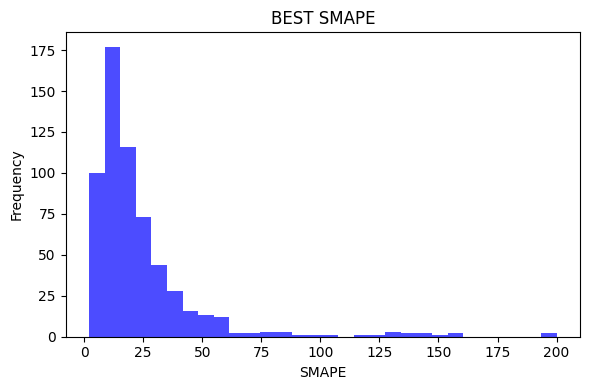

In [78]:
plot_smape_histogram(data=df_accuracy_smape['smape'], figsize=(6, 4))

The histogram illustrates that the forecasting system achieves accurate predictions for most time series (low SMAPE), with some few outliers causing larger errors. The high frequency of low SMAPE values highlights the reliability of the selected models, while the outliers suggest areas where improvements may be needed for specific types of time series. This shows that our forecasting system is coming closer to the target, to get as much as possible error below the 20% SMAPE threshold. 

#### Plot SMAPE Buckets Distributions

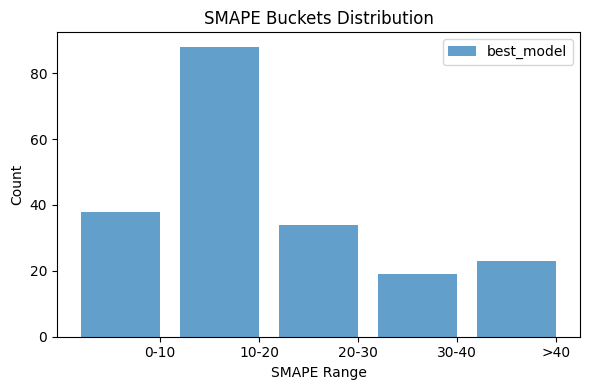

In [79]:
# Example usage
buckets_data = plot_f_system_smape_buckets_distribution(df_accuracy_smape=df_accuracy_smape, figsize=(6, 4))

We can see that our system is performing quite well and most timeseries are falling below the 20% threshold. The next chart shows us this result better.

In [80]:
df_acc_less_20 = plot_err_less_20_SMAPE(buckets_data=buckets_data, figsize=(2,4), no_plot=True)
df_acc_less_20

,model,err_less_20_perc_ts_key
0,best_model,0.62


Finally, we can see that the forecasting system reaches a high accuracy level, with 61% of all timeseries with less than 20% of SMAPE.

## Discussion & Conclusions 

#### Forecasting System Performance

With the selected best-performing models, we achieve a prediction error of less than 20% for 61% of all timeseries. That means 162 out of 266 time series. This is a good starting point for this simple forecasting system. 

We observed the significant advantage of selecting the best-performing model across different test frames. This approach builds a robust system capable of handling outliers effectively while maintaining high accuracy. By leveraging the strengths of each model, we achieve a blended system that maximizes overall performance.

The results demonstrate that the LightGBM model is the dominant performer, delivering the lowest SMAPE values for 44.7% of the timeseries. The second-best model was the Ensemble, which balances multiple methods to perform well across various scenarios. Surprisingly, among the statistical models, the simple WindowAverage outperformed more complex models like ARIMA and ETS in terms of the number of time series for which it delivered the best performance.

This finding underscores that in some cases, simpler models like WindowAverage can outperform more complex methods when data variability causes advanced models to overfit. This reinforces the importance of model selection and adaptability when dealing with diverse timeseries data.

Based on the paper [Forecasting System for Inbound Logistics Material Flows at an International Automotive Company](https://www.mdpi.com/2673-4591/39/1/75), the performance of the forecasting system version 3.0 was 97% for all time series that had a prediction error of less than 20%. This is due to several factors that were not included in this analysis for simplicity:

- **Selection of Best Performing Model**: I used the SMAPE to measure model accuracy, but the paper uses an Exponentially Weighted Moving Average SMAPE that takes into account the "age" of the error. The older the error, the less important it is in determining the best performing model. This exponential decay is based on a decay factor selected with the business experts. 

- **Test Time Frames**: For simplicity, we analyzed only three test frames, namely: Jan 2022 - Apr 2022, May 2022 - Aug 2022, Jul 2022 - Oct 2022. However, the forecasting system in the paper had access to much more test data, as the system has been active since 2018.

- **Hyperparameter Tuning**: Hyperparameter tuning is a powerful tool for selecting the best parameters for each model, but it is also time-consuming. For simplicity, I let most models choose the best parameters using the automated routines provided by their libraries. Except for the tree-based models, where I used the package optuna. This is one additional reason why LightGBM were the best performing algorithms. 

- **Analysis of Historical Production Planning**: For simplicity, we have only included a single production planning record. However, this file is available every month. As explained in the paper, if one analyzes the historical errors of the company's production planning and adds them as features to all models, the accuracy will improve significantly. 

- **Model Pool**: So far I have only explored *statistical models* and *machine learning models*, however we still can explore *deep learning models* and *LLM foundation models* like Chronos, which might also deliver top performance. I will explore those in the final report. 

These are definitely considerations that can be added to improve the overall performance of this forecasting system with Python.

#### Analysis Feature Importance

The feature importance analysis revealed that seasonal features are the most significant, as expected given the seasonality of the data and the model’s ability to capture it. Lag-based features and historical production levels follow in importance. Interestingly, COVID-related features had only little impact, with the first such feature **Poland_Rolling_std_4** ranking 54th out of the 351 available features.

#### Data Quality and Data Preparation



Regarding **data quality and data preparation**, it is important to emphasize that this is a very important step before any model can be trained. My comments are: 

- Involve the business experts to validate any inconsistencies in the data, such as outliers or inaccurate values. 
- Agree with business experts on thresholds that may affect the output, e.g., time series length. 
- Educate business experts about the limitations of predictive algorithms and create contingency plans for outlier processes. 

In this project I could experience what Forbes stated in its article `Cleaning Big Data: Most Time-Consuming, Least Enjoyable Data Science Task` [Ref](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/) that in machine learning (ML) projects, a significant portion of the effort - often as much as 60% - is devoted to data engineering tasks such as data collection, cleaning, and preparation. This is because these phases ensure that the data is both accurate and usable, which is critical to creating meaningful ML models. Surveys from sources such as Anaconda and Kaggle have consistently shown that data scientists spend a large portion of their time on these tasks. Specifically, Anaconda found that data cleaning can take more than 45% of the time on many projects, and according to O'Reilly, handling upstream data unification and cleaning often requires complex ML pipelines, especially in large-scale data environments. It is important not to underestimate this critical step and plan accordingly.
 


#### Hypothesis Analysis

At the begining, we stated the hypothesis: "There are new forecasting methods which can deliver better accuracy than traditional statistical methods". 

The results thus far have demonstrated that the LightGBM model consistently outperforms traditional statistical models such as ARIMA, ETS, CTS, and Window Average. This highlights the exceptional capability of tree-based models in the context of forecasting. This finding aligns with one of the key insights from the [M5](https://www.sciencedirect.com/science/article/pii/S0169207021001874) Forecasting Competion , which also emphasized the effectiveness of machine learning approaches over conventional statistical methods.